## Fine-tuning with BERT Model

#### Data Preperation

In [ ]:
import pandas as pd

# Load your DataFrame
df = pd.read_csv('/content/drive/MyDrive/subset result.csv')
df['item_1A'] = df['item_1A'].astype(str)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# split train and test set
train_df, val_df = train_test_split(df, test_size=0.2, random_state=29)

# balance 2 class
df_majority = train_df[train_df.high_30 == 1]
df_minority = train_df[train_df.high_30 == 0]
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=29)

train_df = pd.concat([df_majority_downsampled, df_minority])
train_df = resample(train_df,
                    replace=False,
                    n_samples=len(train_df),
                    random_state=29)

# Display new class counts
print(train_df.high_30.value_counts())

0    323
1    323
Name: high_30, dtype: int64


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# tokenize the text
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def tokenize_function(examples):
    return tokenizer(examples['item_1A'], padding='max_length', truncation=True, max_length=512)

train_dataset = train_df.apply(tokenize_function, axis=1)
val_dataset = val_df.apply(tokenize_function, axis=1)


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

# Store labels of train and validation set
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['high_30'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train = TextDataset(train_dataset, train_df['high_30'].tolist())
val = TextDataset(val_dataset, val_df['high_30'].tolist())

In [ ]:
# Create attention mask

train_attention_mask = []
train_input_ids = []
for element in train_dataset:
  train_attention_mask.append(element['attention_mask'])
  train_input_ids.append(element['input_ids'])

test_attention_mask = []
test_input_ids = []
for element in val_dataset:
  test_attention_mask.append(element['attention_mask'])
  test_input_ids.append(element['input_ids'])

In [ ]:
# Store structured train and validation data into dataframes
df_train = pd.DataFrame({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_mask,
    'labels': train.labels
})

df_test = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_mask,
    'labels': val.labels
})

In [ ]:
# Convert data to tensor format

dataset = []
for _, row in df_train.iterrows():
    data_point = {
        'input_ids': torch.tensor(row['input_ids']),
        'attention_mask': torch.tensor(row['attention_mask']),
        'labels': row['labels']
    }
    dataset.append(data_point)

test_dataset = []
for _, row in df_test.iterrows():
    data_point = {
        'input_ids': torch.tensor(row['input_ids']),
        'attention_mask': torch.tensor(row['attention_mask']),
        'labels': row['labels']
    }
    test_dataset.append(data_point)

In [ ]:
# create batches

def create_batches(dataset, batch_size):
    batches = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]
        batch_input_ids = torch.stack([item['input_ids'] for item in batch])
        batch_attention_mask = torch.stack([item['attention_mask'] for item in batch])
        batch_labels = torch.tensor([item['labels'] for item in batch])

        batches.append({
            'input_ids': batch_input_ids,
            'attention_mask': batch_attention_mask,
            'labels': batch_labels
        })
    return batches

# Example usage
batch_size = 16
batches = create_batches(dataset, batch_size)
test_batches = create_batches(test_dataset, batch_size)

#### Learning Rate Tuning

In [ ]:
# Model and optimizer
from transformers import AdamW

actual_labels = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for lr in [1e-3, 1e-5, 1e-7, 1e-9]:
    print(lr)
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-cased',
        output_hidden_states=True)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Number of training epochs
    num_epochs = 16

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)
        # print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

0.001


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 0.9235166708628336
Epoch 0: Average Validation Loss: 1.2401877641677856
Epoch 1: Average Training Loss: 1.0931898554166157
Epoch 1: Average Validation Loss: 0.7252647876739502
Epoch 2: Average Training Loss: 0.8244967460632324
Epoch 2: Average Validation Loss: 0.7445230185985565
Epoch 3: Average Training Loss: 0.7060555020968119
Epoch 3: Average Validation Loss: 0.6995245516300201
Epoch 4: Average Training Loss: 0.7502637505531311
Epoch 4: Average Validation Loss: 0.6853238940238953
Epoch 5: Average Training Loss: 0.7103614012400309
Epoch 5: Average Validation Loss: 0.6983706057071686
Epoch 6: Average Training Loss: 0.7157374223073324
Epoch 6: Average Validation Loss: 1.9444032311439514
Epoch 7: Average Training Loss: 1.370842734972636
Epoch 7: Average Validation Loss: 0.7112303972244263
Epoch 8: Average Training Loss: 0.7146676580111185
Epoch 8: Average Validation Loss: 0.7076599299907684
Epoch 9: Average Training Loss: 0.6934014956156412
Epoch 9: Avera

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 0.7210384209950765
Epoch 0: Average Validation Loss: 0.7337098717689514
Epoch 1: Average Training Loss: 0.6713559627532959
Epoch 1: Average Validation Loss: 0.7360829710960388
Epoch 2: Average Training Loss: 0.6438313325246176
Epoch 2: Average Validation Loss: 0.7545042335987091
Epoch 3: Average Training Loss: 0.652965267499288
Epoch 3: Average Validation Loss: 0.7546887993812561
Epoch 4: Average Training Loss: 0.6750729481379191
Epoch 4: Average Validation Loss: 0.7508493661880493
Epoch 5: Average Training Loss: 0.6434392134348551
Epoch 5: Average Validation Loss: 0.7455426454544067
Epoch 6: Average Training Loss: 0.6041501561800638
Epoch 6: Average Validation Loss: 0.7321276366710663
Epoch 7: Average Training Loss: 0.6343328356742859
Epoch 7: Average Validation Loss: 0.7221474051475525
Epoch 8: Average Training Loss: 0.6074232657750448
Epoch 8: Average Validation Loss: 0.7167467772960663
Epoch 9: Average Training Loss: 0.5765221118927002
Epoch 9: Avera

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7082482973734537
Epoch 0: Average Validation Loss: 0.6929747462272644
Epoch 1: Average Training Loss: 0.7006465792655945
Epoch 1: Average Validation Loss: 0.6934650540351868
Epoch 2: Average Training Loss: 0.69600776831309
Epoch 2: Average Validation Loss: 0.6938537955284119
Epoch 3: Average Training Loss: 0.7144111196200053
Epoch 3: Average Validation Loss: 0.6938063204288483
Epoch 4: Average Training Loss: 0.6900124549865723
Epoch 4: Average Validation Loss: 0.6937737762928009
Epoch 5: Average Training Loss: 0.6939492225646973
Epoch 5: Average Validation Loss: 0.6937564313411713
Epoch 6: Average Training Loss: 0.6977731188138326
Epoch 6: Average Validation Loss: 0.6938489675521851
Epoch 7: Average Training Loss: 0.7069937984148661
Epoch 7: Average Validation Loss: 0.6938519179821014
Epoch 8: Average Training Loss: 0.6843986709912618
Epoch 8: Average Validation Loss: 0.6939083933830261
Epoch 9: Average Training Loss: 0.7171843647956848
Epoch 9: Averag

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.69782022635142
Epoch 0: Average Validation Loss: 0.6840799450874329
Epoch 1: Average Training Loss: 0.7187349001566569
Epoch 1: Average Validation Loss: 0.6840800046920776
Epoch 2: Average Training Loss: 0.710434635480245
Epoch 2: Average Validation Loss: 0.6840803921222687
Epoch 3: Average Training Loss: 0.7261869708697001
Epoch 3: Average Validation Loss: 0.6840808689594269
Epoch 4: Average Training Loss: 0.7051628232002258
Epoch 4: Average Validation Loss: 0.6840808093547821
Epoch 5: Average Training Loss: 0.7088308930397034
Epoch 5: Average Validation Loss: 0.6840810775756836
Epoch 6: Average Training Loss: 0.6898635625839233
Epoch 6: Average Validation Loss: 0.6840818226337433
Epoch 7: Average Training Loss: 0.6903713345527649
Epoch 7: Average Validation Loss: 0.684082418680191
Epoch 8: Average Training Loss: 0.7169421911239624
Epoch 8: Average Validation Loss: 0.6840828657150269
Epoch 9: Average Training Loss: 0.6898860136667887
Epoch 9: Average 

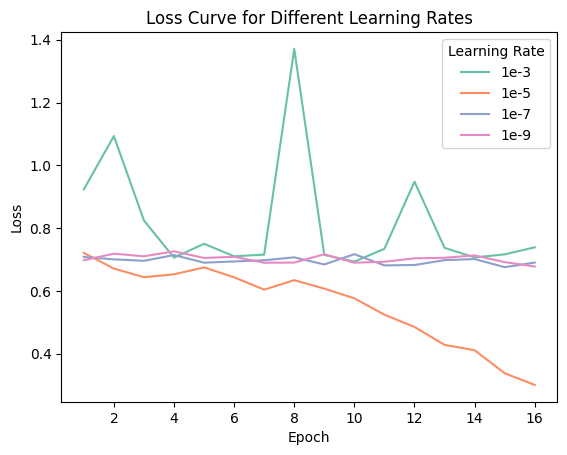

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot line plot for each parameter trial
data = {'Epoch': list(range(1, 17))}
for i, loss_list in enumerate(train_loss_list):
    data[["1e-3", "1e-5", "1e-7", "1e-9"][i]] = loss_list

df = pd.DataFrame(data)
df_melted = df.melt('Epoch', var_name='Learning Rate', value_name='Loss')

# Plotting with Seaborn
sns.lineplot(x='Epoch', y='Loss', hue='Learning Rate', data=df_melted, palette="Set2")
plt.title('Loss Curve for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Learning Rate')
plt.show()

#### Batch Size Tuning

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for batch in [2, 4, 8, 16]:
    print(batch)

    batch_size = batch
    batches = create_batches(dataset, batch_size)
    test_batches = create_batches(test_dataset, batch_size)
    model = BertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Number of training epochs
    num_epochs = 16

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)
        # print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

2


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.4.output.dense.weight', 'encoder.la

Epoch 0: Average Training Loss: 0.9065307937562466
Epoch 0: Average Validation Loss: 0.6956460118293762
Epoch 1: Average Training Loss: 0.7765650004148483
Epoch 1: Average Validation Loss: 0.6910102486610412
Epoch 2: Average Training Loss: 0.7448389207323393
Epoch 2: Average Validation Loss: 0.6905756235122681
Epoch 3: Average Training Loss: 0.7599000607927641
Epoch 3: Average Validation Loss: 0.6917639911174774
Epoch 4: Average Training Loss: 0.7766039669513702
Epoch 4: Average Validation Loss: 0.6921422779560089
Epoch 5: Average Training Loss: 0.7630985279877981
Epoch 5: Average Validation Loss: 0.6925868213176727
Epoch 6: Average Training Loss: 0.731463834643364
Epoch 6: Average Validation Loss: 0.6930679023265839
Epoch 7: Average Training Loss: 0.7326124211152395
Epoch 7: Average Validation Loss: 0.6940298438072204
Epoch 8: Average Training Loss: 0.7395454819003741
Epoch 8: Average Validation Loss: 0.6937805533409118
Epoch 9: Average Training Loss: 0.7219080751140913
Epoch 9: Avera

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.857508048415184
Epoch 0: Average Validation Loss: 0.6918293595314026
Epoch 1: Average Training Loss: 0.7638033777475357
Epoch 1: Average Validation Loss: 0.6911250352859497
Epoch 2: Average Training Loss: 0.7213054895401001
Epoch 2: Average Validation Loss: 0.6950511813163758
Epoch 3: Average Training Loss: 0.7320809115966161
Epoch 3: Average Validation Loss: 0.6948792219161988
Epoch 4: Average Training Loss: 0.7236919701099396
Epoch 4: Average Validation Loss: 0.6992098093032837
Epoch 5: Average Training Loss: 0.7232377181450526
Epoch 5: Average Validation Loss: 0.7025628566741944
Epoch 6: Average Training Loss: 0.7155553698539734
Epoch 6: Average Validation Loss: 0.7052503824234009
Epoch 7: Average Training Loss: 0.7149026940266291
Epoch 7: Average Validation Loss: 0.7096611022949219
Epoch 8: Average Training Loss: 0.7262073506911596
Epoch 8: Average Validation Loss: 0.7113025307655334
Epoch 9: Average Training Loss: 0.7144291698932648
Epoch 9: Avera

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.7928117116292318
Epoch 0: Average Validation Loss: 0.6964432795842489
Epoch 1: Average Training Loss: 0.7139357129732767
Epoch 1: Average Validation Loss: 0.7022501031557719
Epoch 2: Average Training Loss: 0.707090804974238
Epoch 2: Average Validation Loss: 0.7087226112683614
Epoch 3: Average Training Loss: 0.7150565683841705
Epoch 3: Average Validation Loss: 0.7146816849708557
Epoch 4: Average Training Loss: 0.7085241774717966
Epoch 4: Average Validation Loss: 0.7230993906656901
Epoch 5: Average Training Loss: 0.7016761302947998
Epoch 5: Average Validation Loss: 0.7287740310033163
Epoch 6: Average Training Loss: 0.7031285365422567
Epoch 6: Average Validation Loss: 0.734299878279368
Epoch 7: Average Training Loss: 0.7075587113698324
Epoch 7: Average Validation Loss: 0.7444480260213217
Epoch 8: Average Training Loss: 0.7033613324165344
Epoch 8: Average Validation Loss: 0.7526820699373881
Epoch 9: Average Training Loss: 0.6908973952134451
Epoch 9: Averag

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.7630451122919718
Epoch 0: Average Validation Loss: 0.7135531306266785
Epoch 1: Average Training Loss: 0.7032441894213358
Epoch 1: Average Validation Loss: 0.7511202692985535
Epoch 2: Average Training Loss: 0.7045589089393616
Epoch 2: Average Validation Loss: 0.7177504003047943
Epoch 3: Average Training Loss: 0.7097621560096741
Epoch 3: Average Validation Loss: 0.7188116014003754
Epoch 4: Average Training Loss: 0.7203605771064758
Epoch 4: Average Validation Loss: 0.7314024567604065
Epoch 5: Average Training Loss: 0.6978601018587748
Epoch 5: Average Validation Loss: 0.7564506232738495
Epoch 6: Average Training Loss: 0.6780588229497274
Epoch 6: Average Validation Loss: 0.7584607303142548
Epoch 7: Average Training Loss: 0.6689616640408834
Epoch 7: Average Validation Loss: 0.7477611899375916
Epoch 8: Average Training Loss: 0.6696126063664755
Epoch 8: Average Validation Loss: 0.7512038350105286
Epoch 9: Average Training Loss: 0.6900050044059753
Epoch 9: Aver

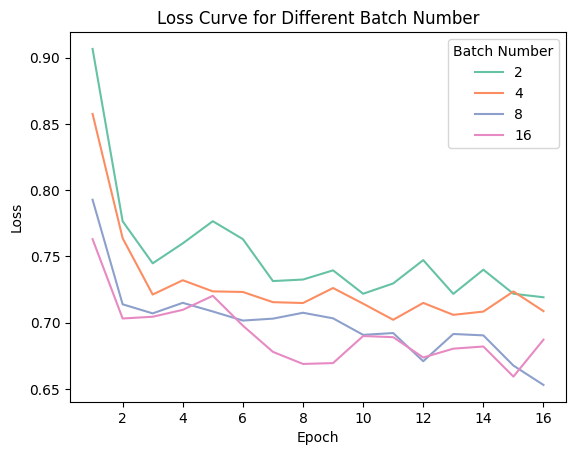

In [ ]:
# plot line plot for each parameter trial
data = {'Epoch': list(range(1, 17))}
for i, loss_list in enumerate(train_loss_list):
    data[["2", "4", "8", "16"][i]] = loss_list

df = pd.DataFrame(data)
df_melted = df.melt('Epoch', var_name='Batch Number', value_name='Loss')

# Plotting with Seaborn
sns.lineplot(x='Epoch', y='Loss', hue='Batch Number', data=df_melted, palette="Set2")
plt.title('Loss Curve for Different Batch Number')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Batch Number')
plt.show()

#### Dropout Probability Tuning

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

batch_size = 16
batches = create_batches(dataset, batch_size)
test_batches = create_batches(test_dataset, batch_size)

for dropout in [0.1, 0.2, 0.3, 0.5]:
    # print(lr)
    model = BertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True, attention_probs_dropout_prob=dropout)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Number of training epochs
    num_epochs = 16

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)
        # print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.7795614997545878
Epoch 0: Average Validation Loss: 0.7741176187992096
Epoch 1: Average Training Loss: 0.704269270102183
Epoch 1: Average Validation Loss: 0.7048864662647247
Epoch 2: Average Training Loss: 0.741713285446167
Epoch 2: Average Validation Loss: 0.6949111521244049
Epoch 3: Average Training Loss: 0.7031427224477133
Epoch 3: Average Validation Loss: 0.7439586520195007
Epoch 4: Average Training Loss: 0.7022669116655985
Epoch 4: Average Validation Loss: 0.7670084834098816
Epoch 5: Average Training Loss: 0.6652624805768331
Epoch 5: Average Validation Loss: 0.7298346161842346
Epoch 6: Average Training Loss: 0.6966012318929037
Epoch 6: Average Validation Loss: 0.7169019877910614
Epoch 7: Average Training Loss: 0.7032818794250488
Epoch 7: Average Validation Loss: 0.7216767370700836
Epoch 8: Average Training Loss: 0.6839156349500021
Epoch 8: Average Validation Loss: 0.735622376203537
Epoch 9: Average Training Loss: 0.672646721204122
Epoch 9: Average 

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.8243091305096945
Epoch 0: Average Validation Loss: 0.8557838797569275
Epoch 1: Average Training Loss: 0.7047104636828104
Epoch 1: Average Validation Loss: 0.7186919748783112
Epoch 2: Average Training Loss: 0.784166157245636
Epoch 2: Average Validation Loss: 0.6987952589988708
Epoch 3: Average Training Loss: 0.7302201191584269
Epoch 3: Average Validation Loss: 0.7408711910247803
Epoch 4: Average Training Loss: 0.7120097875595093
Epoch 4: Average Validation Loss: 0.7797471880912781
Epoch 5: Average Training Loss: 0.6890124281247457
Epoch 5: Average Validation Loss: 0.7379777133464813
Epoch 6: Average Training Loss: 0.6745365460713705
Epoch 6: Average Validation Loss: 0.714078277349472
Epoch 7: Average Training Loss: 0.7065349618593851
Epoch 7: Average Validation Loss: 0.7168146967887878
Epoch 8: Average Training Loss: 0.706813375155131
Epoch 8: Average Validation Loss: 0.7280965447425842
Epoch 9: Average Training Loss: 0.7093314528465271
Epoch 9: Average

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.7676565845807394
Epoch 0: Average Validation Loss: 0.7217909693717957
Epoch 1: Average Training Loss: 0.710475226243337
Epoch 1: Average Validation Loss: 0.680702269077301
Epoch 2: Average Training Loss: 0.708075205485026
Epoch 2: Average Validation Loss: 0.685773640871048
Epoch 3: Average Training Loss: 0.7100314696629842
Epoch 3: Average Validation Loss: 0.7063626945018768
Epoch 4: Average Training Loss: 0.7007381319999695
Epoch 4: Average Validation Loss: 0.7178163230419159
Epoch 5: Average Training Loss: 0.6842436989148458
Epoch 5: Average Validation Loss: 0.7104614078998566
Epoch 6: Average Training Loss: 0.7003020445505778
Epoch 6: Average Validation Loss: 0.7098996043205261
Epoch 7: Average Training Loss: 0.676427960395813
Epoch 7: Average Validation Loss: 0.7176436185836792
Epoch 8: Average Training Loss: 0.6901972492535909
Epoch 8: Average Validation Loss: 0.7368151843547821
Epoch 9: Average Training Loss: 0.6983449459075928
Epoch 9: Average V

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.o

Epoch 0: Average Training Loss: 0.7646130522092184
Epoch 0: Average Validation Loss: 0.729206770658493
Epoch 1: Average Training Loss: 0.6827356616655985
Epoch 1: Average Validation Loss: 0.6946112811565399
Epoch 2: Average Training Loss: 0.7206920782725016
Epoch 2: Average Validation Loss: 0.6908489167690277
Epoch 3: Average Training Loss: 0.7123077114423116
Epoch 3: Average Validation Loss: 0.7348007261753082
Epoch 4: Average Training Loss: 0.7184844811757406
Epoch 4: Average Validation Loss: 0.7296775877475739
Epoch 5: Average Training Loss: 0.6820230086644491
Epoch 5: Average Validation Loss: 0.7067945003509521
Epoch 6: Average Training Loss: 0.6980023582776388
Epoch 6: Average Validation Loss: 0.7096989750862122
Epoch 7: Average Training Loss: 0.7133042414983114
Epoch 7: Average Validation Loss: 0.720400333404541
Epoch 8: Average Training Loss: 0.7102688550949097
Epoch 8: Average Validation Loss: 0.7429223656654358
Epoch 9: Average Training Loss: 0.6913680831591288
Epoch 9: Averag

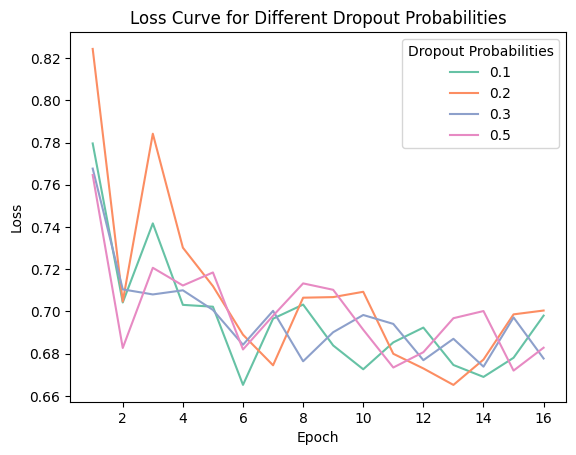

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Updating the DataFrame without "Loss Series" in the series labels
data = {'Epoch': list(range(1, 17))}
for i, loss_list in enumerate(train_loss_list):
    data[["0.1", "0.2", "0.3", "0.5"][i]] = loss_list  # Using just the series label like '1e-3'

df = pd.DataFrame(data)
df_melted = df.melt('Epoch', var_name='dropout', value_name='Loss')

# Plotting with Seaborn
sns.lineplot(x='Epoch', y='Loss', hue='dropout', data=df_melted, palette="Set2")
plt.title('Loss Curve for Different Dropout Probabilities')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dropout Probabilities')
plt.show()

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels_train = train_df['high_30'].to_list()
actual_labels_val = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for lr in [1e-5]:
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-cased',
        output_hidden_states=True, attention_probs_dropout_prob=0.5)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Number of training epochs
    num_epochs = 4

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels_train, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels_train)
        print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels_val, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels_val)
        print("Accuracy:", accuracy)
        print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 0.6975015707132293
Accuracy: 0.521671826625387
Epoch 0: Average Validation Loss: 0.6664661948497479
Accuracy: 0.63
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Epoch 1: Average Training Loss: 0.6803775095358128
Accuracy: 0.5696594427244582
Epoch 1: Average Validation Loss: 0.6621629504057077
Accuracy: 0.66
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1